In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/AI대학원1-2/그래프및네트워크/final/'
%pip install dgl

Mounted at /content/drive
/content/drive/My Drive/AI대학원1-2/그래프및네트워크/final
     |████████████████████████████████| 3.6MB 11.7MB/s 


In [2]:
import dgl 
import torch
import numpy as np 
def build_graph():
  g = dgl.DGLGraph()
  g.add_nodes(1000) # number of nodes , start from 0 (hw start from 1)
  edge_ls = open("edge_list.txt", "r");
  edge_all = []
  
  while True:
    line = edge_ls.readline()
    if not line:
      break
    # node index 0~999로 하기위해 -1씩 
    edge_all.append(tuple(np.subtract(tuple(map(int,line.strip().split())),(1,1))))
  src, dst = tuple(zip(*edge_all))
  g.add_edges(src, dst)
  g.add_edges(dst, src) #bidirectional 
  return g 
G = build_graph()
G.number_of_nodes()

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


1000

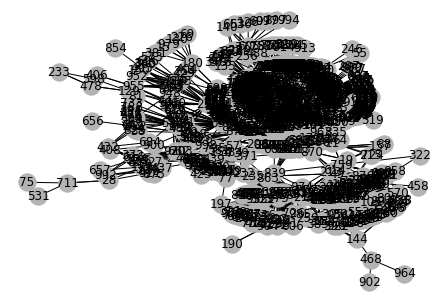

In [ ]:
import networkx as nx

nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7,.7,.7]])

In [3]:
cls_info = open("class_info.txt", "r");
labeled_nodes = []
labels = []
while True:
  line = cls_info.readline()
  if not line:
    break
  line_ = list(np.subtract(list(map(int,line.strip().split())),[1,0]))
  if line_[1] == 1:
    labeled_nodes.append(line_[0]) # add node num
    labels.append(1)
  elif line_[1] == -1:
    labeled_nodes.append(line_[0])
    labels.append(0) #append 0 instead of -1 
  else: 
    continue # pass the unlabeld ; 0 
print(labeled_nodes)
print(labels)

[5, 6, 8, 14, 15, 16, 18, 25, 30, 32, 35, 37, 40, 53, 61, 62, 70, 72, 83, 87, 88, 96, 100, 102, 111, 114, 116, 117, 119, 121, 135, 140, 149, 154, 161, 162, 164, 169, 172, 173, 182, 191, 193, 197, 204, 211, 212, 214, 219, 228, 230, 234, 235, 239, 241, 242, 259, 260, 268, 276, 278, 283, 287, 288, 299, 311, 323, 325, 329, 330, 332, 350, 353, 357, 362, 371, 372, 373, 374, 376, 385, 388, 408, 409, 414, 418, 419, 420, 422, 430, 437, 444, 447, 449, 451, 452, 453, 459, 463, 466, 467, 469, 481, 485, 491, 493, 500, 504, 513, 516, 517, 526, 527, 529, 534, 537, 538, 540, 542, 543, 548, 565, 571, 572, 578, 579, 582, 585, 600, 604, 608, 609, 613, 615, 626, 632, 636, 641, 642, 655, 680, 681, 682, 683, 684, 686, 692, 704, 714, 721, 727, 739, 745, 756, 757, 758, 759, 762, 766, 768, 773, 795, 806, 823, 825, 833, 835, 849, 852, 856, 857, 859, 862, 864, 877, 889, 892, 894, 896, 900, 908, 909, 910, 911, 915, 925, 927, 941, 946, 950, 954, 970, 971, 972, 974, 976, 980, 989, 996, 998]
[1, 1, 1, 1, 0, 1, 1, 0,

In [185]:
#################GCN##################
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)
'''
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size1, hidden_size2, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size1)
        self.gcn2 = GCNLayer(hidden_size1, hidden_size2)
        self.gcn3 = GCNLayer(hidden_size2, num_classes)
      
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g,h)
        h = torch.relu(h)
        h = self.gcn3(g,h)
        return h
'''
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)
      
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        #h = F.leaky_relu(h)
        #h = F.elu(h)
        h = self.gcn2(g,h)
        return h

#net = GCN(1000, 64, 32, 2)
net = GCN(1000, 64, 2)
print(net)

GCN(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=1000, out_features=64, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [186]:
inputs = torch.eye(1000)
#list2tensor
labeled_nodes = torch.tensor(labeled_nodes)
labels = torch.tensor(labels)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
f = open("GCN.txt", 'w')
for epoch in range(40):
  logits = net(G, inputs)
  all_logits.append(logits.detach())
  logp = F.log_softmax(logits, 1)
  loss = F.nll_loss(logp[labeled_nodes], labels)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print('epoch {} | loss: {}'.format(epoch,loss.item()))
  f.write(str(loss.item())+'\n')
f.close()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


epoch 0 | loss: 0.6902573108673096
epoch 1 | loss: 4.429078578948975
epoch 2 | loss: 1.56268310546875
epoch 3 | loss: 3.3176894187927246
epoch 4 | loss: 1.5670465230941772
epoch 5 | loss: 0.8027867674827576
epoch 6 | loss: 0.8630746603012085
epoch 7 | loss: 0.9844700694084167
epoch 8 | loss: 0.9194190502166748
epoch 9 | loss: 0.7448106408119202
epoch 10 | loss: 0.581279993057251
epoch 11 | loss: 0.43369752168655396
epoch 12 | loss: 0.3176570236682892
epoch 13 | loss: 0.2632559537887573
epoch 14 | loss: 0.2801111042499542
epoch 15 | loss: 0.31962940096855164
epoch 16 | loss: 0.3474128842353821
epoch 17 | loss: 0.33385932445526123
epoch 18 | loss: 0.31164324283599854
epoch 19 | loss: 0.27850058674812317
epoch 20 | loss: 0.24415525794029236
epoch 21 | loss: 0.2191840410232544
epoch 22 | loss: 0.198165625333786
epoch 23 | loss: 0.19159568846225739
epoch 24 | loss: 0.18111084401607513
epoch 25 | loss: 0.16134552657604218
epoch 26 | loss: 0.14451941847801208
epoch 27 | loss: 0.13188455998897

In [96]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
acc = evaluate(net, G, inputs, labels, labeled_nodes) #early stopping @40epoch
print(acc)

0.99


In [133]:
#################SAGEConv##################
from dgl.nn import SAGEConv
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, num_classes, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        #h = F.relu(h)
        #h = F.elu(h)
        h = F.leaky_relu(h)
        h = self.conv2(g, h)
        return h
'''
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats1,h_feats2, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats1, 'mean')
        self.conv2 = SAGEConv(h_feats1, h_feats2, 'mean')
        self.conv3 = SAGEConv(h_feats2, num_classes, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv3(g,h)
        return h
'''
#net = GraphSAGE(1000, 64, 32, 2)
net = GraphSAGE(1000, 64, 2)
print(net)

GraphSAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_self): Linear(in_features=1000, out_features=64, bias=True)
    (fc_neigh): Linear(in_features=1000, out_features=64, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_self): Linear(in_features=64, out_features=2, bias=True)
    (fc_neigh): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [134]:
inputs = torch.eye(1000)
#list2tensor
labeled_nodes = torch.tensor(labeled_nodes)
labels = torch.tensor(labels)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
f = open("SAGEConv.txt", 'w')
for epoch in range(20):
  logits = net(G, inputs)
  all_logits.append(logits.detach())
  logp = F.log_softmax(logits, 1)
  loss = F.nll_loss(logp[labeled_nodes], labels)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print('epoch {} | loss: {}'.format(epoch,loss.item()))
  f.write(str(loss.item())+'\n')
f.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


epoch 0 | loss: 0.7019528150558472
epoch 1 | loss: 0.5692905187606812
epoch 2 | loss: 0.44887691736221313
epoch 3 | loss: 0.3340497612953186
epoch 4 | loss: 0.23252543807029724
epoch 5 | loss: 0.1542462259531021
epoch 6 | loss: 0.10076206922531128
epoch 7 | loss: 0.06688693165779114
epoch 8 | loss: 0.04531759396195412
epoch 9 | loss: 0.031056217849254608
epoch 10 | loss: 0.021245306357741356
epoch 11 | loss: 0.014404683373868465
epoch 12 | loss: 0.00967196375131607
epoch 13 | loss: 0.006470571272075176
epoch 14 | loss: 0.004349499940872192
epoch 15 | loss: 0.0029564311262220144
epoch 16 | loss: 0.002042145933955908
epoch 17 | loss: 0.0014394863974303007
epoch 18 | loss: 0.0010368699440732598
epoch 19 | loss: 0.000763908785302192


In [135]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
acc = evaluate(net, G, inputs, labels, labeled_nodes)
print(acc)

1.0


In [ ]:
_, indices = torch.max(net(G,inputs),dim=1)
print(indices) # 1_thisOutput=1_hwValue , 0_thisOutput=-1_hwValue  --> need to be text file without trainset 

tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,

In [4]:
#################Graph Attention##################
from dgl.nn.pytorch import GATConv
import torch
import torch.nn as nn
import torch.nn.functional as F


class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

net = GAT(G,in_dim=1000, hidden_dim=32, out_dim=2, num_heads=2) # g, in_dim, hidden_dim, out_dim, num_heads
print(net)


GAT(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=1000, out_features=32, bias=False)
        (attn_fc): Linear(in_features=64, out_features=1, bias=False)
      )
      (1): GATLayer(
        (fc): Linear(in_features=1000, out_features=32, bias=False)
        (attn_fc): Linear(in_features=64, out_features=1, bias=False)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=64, out_features=2, bias=False)
        (attn_fc): Linear(in_features=4, out_features=1, bias=False)
      )
    )
  )
)


In [5]:
inputs = torch.eye(1000)
#list2tensor
labeled_nodes = torch.tensor(labeled_nodes)
labels = torch.tensor(labels)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
f = open("GAT.txt", 'w')
for epoch in range(70):
  logits = net(inputs)
  all_logits.append(logits.detach())
  logp = F.log_softmax(logits, 1)
  loss = F.nll_loss(logp[labeled_nodes], labels)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print('epoch {} | loss: {}'.format(epoch,loss.item()))
  f.write(str(loss.item())+'\n')
f.close()

epoch 0 | loss: 0.6911803483963013
epoch 1 | loss: 0.6448437571525574
epoch 2 | loss: 0.5975217223167419
epoch 3 | loss: 0.5481191277503967
epoch 4 | loss: 0.49708402156829834
epoch 5 | loss: 0.4450148344039917
epoch 6 | loss: 0.39280033111572266
epoch 7 | loss: 0.34166058897972107
epoch 8 | loss: 0.2935633659362793
epoch 9 | loss: 0.25085166096687317
epoch 10 | loss: 0.2151683270931244
epoch 11 | loss: 0.18708471953868866
epoch 12 | loss: 0.1659376323223114
epoch 13 | loss: 0.15009690821170807
epoch 14 | loss: 0.13799887895584106
epoch 15 | loss: 0.12804155051708221
epoch 16 | loss: 0.11910367012023926
epoch 17 | loss: 0.11055530607700348
epoch 18 | loss: 0.1015738770365715
epoch 19 | loss: 0.09239449352025986
epoch 20 | loss: 0.08357811719179153
epoch 21 | loss: 0.07593889534473419
epoch 22 | loss: 0.069825179874897
epoch 23 | loss: 0.06469853222370148
epoch 24 | loss: 0.06007172912359238
epoch 25 | loss: 0.05574505031108856
epoch 26 | loss: 0.051725298166275024
epoch 27 | loss: 0.04

In [6]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
acc = evaluate(net, G, inputs, labels, labeled_nodes)
print(acc)

1.0


In [14]:
_, indices = torch.max(net(inputs),dim=1)
print(indices) # 1_thisOutput=1_hwValue , 0_thisOutput=-1_hwValue  --> need to be text file without trainset
cls_info = open("class_info.txt", "r");
out_nodes = []
out_labels = []
while True:
  line = cls_info.readline()
  if not line:
    break
  line_ = list(np.subtract(list(map(int,line.strip().split())),[1,0])) #from 0~
  if line_[1] == 0: #deal with only test data 800 nodes 
    out_nodes.append(int(line_[0])+1)
    out_label = int(indices[int(line_[0])].item())
    if out_label == 1:
      out_labels.append(1)
    if out_label == 0: #0 is originally -1 
      out_labels.append(-1)
  else :
    continue
print(len(out_nodes),out_nodes)
print(len(out_labels),out_labels)

f = open("result_woosungJang.txt", 'w')
for i in range(800):
    data = str(out_nodes[i]) + '\t' + str(out_labels[i]) + '\n' 
    f.write(data)
f.close()

tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,